In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler

#import dask.dataframe as dd

from datetime import datetime

In [2]:
# cluster.close()
# client.close()

In [3]:
#from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
#client = Client(cluster)
# client = Client(n_workers=4, threads_per_worker=4, memory_limit='12GB')
# client

In [4]:
import keras 

from keras.preprocessing import sequence
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, LeakyReLU
from keras.layers import Embedding
from keras.layers import Concatenate, Flatten, Reshape, Lambda
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, LSTM
from keras.utils import plot_model
from keras import backend as K

from keras.datasets import imdb

Using TensorFlow backend.


In [5]:
#K.tensorflow_backend._get_available_gpus()

Helpful links:
1. Inverse of np.log1p: https://stackoverflow.com/questions/50049891/what-is-the-inverse-of-numpys-log1p
2. Building parallel keras model: https://stackoverflow.com/questions/43151775/how-to-have-parallel-convolutional-layers-in-keras
3. How to make parallel keras models: https://datascience.stackexchange.com/questions/39407/how-to-make-two-parallel-convolutional-neural-networks-in-keras
4. 2 parallel keras layers: https://stackoverflow.com/questions/51546075/two-parallel-conv2d-layers-keras
5. Setting up Conv1D and LSTM: https://stackoverflow.com/questions/51344610/how-to-setup-1d-convolution-and-lstm-in-keras
6. Take average of LSTM hidden states using Lambda: https://stackoverflow.com/questions/51479940/average-channels-of-convolutional-layer-keras
7. Preparing categorical variable for neural networks: https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/
8. Tutorial for using keras for time series (no generators used): https://medium.com/@jdwittenauer/deep-learning-with-keras-structured-time-series-37a66c6aeb28


In [6]:
train = pd.read_csv("gs://123test_bucket/train.csv")

In [7]:
reading = train['meter_reading']
train['meter_reading'] = np.log1p(train['meter_reading'])

scaler1 = MinMaxScaler()
train['meter_reading'] = scaler1.fit_transform(X=np.reshape(train['meter_reading'].values, (-1, 1))).reshape(len(train),)

In [8]:
train['meter_reading'].mean()

0.2452794762030242

#### Reading Test Data

In [9]:
test = pd.read_csv("gs://123test_bucket/test.csv")

#### Obtaining Month, Day of the Week, and Hour

In [10]:
train.timestamp = pd.to_datetime(train.timestamp)

test.timestamp = pd.to_datetime(test.timestamp)

In [11]:
len(train), len(test)

(20216100, 41697600)

#### Reading weather data

In [12]:
weather_train = pd.read_csv("gs://123test_bucket/weather_train.csv")

In [13]:
weather_test = pd.read_csv("gs://123test_bucket/weather_test.csv")

In [14]:
meta = pd.read_csv("gs://123test_bucket/building_metadata.csv")

In [15]:
weather_train.timestamp = pd.to_datetime(weather_train.timestamp)

weather_test.timestamp = pd.to_datetime(weather_test.timestamp)

weather_train['month'] = weather_train.timestamp.dt.month
weather_train['dayofweek'] = weather_train.timestamp.dt.dayofweek
weather_train['hour'] = weather_train.timestamp.dt.hour

weather_test['month'] = weather_test.timestamp.dt.month
weather_test['dayofweek'] = weather_test.timestamp.dt.dayofweek
weather_test['hour'] = weather_test.timestamp.dt.hour

In [16]:
train_meta_w = pd.merge(weather_train, meta, on='site_id')
test_meta_w = pd.merge(weather_test, meta, on='site_id')

#### Scaling Data

In [17]:
train_meta_w = train_meta_w.fillna(0)
test_meta_w = test_meta_w.fillna(0)

In [18]:
scaler2 = MinMaxScaler()
num_cols = ['air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'square_feet', 'floor_count']
scaler2.fit(train_meta_w[num_cols])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [19]:
train_meta_w[num_cols] = scaler2.transform(train_meta_w[num_cols])
test_meta_w[num_cols] = scaler2.transform(test_meta_w[num_cols])

#### Encoding Categorical Data

In [20]:
enc = OrdinalEncoder()
cat_cols = ['site_id', 'hour', 'dayofweek', 'month', 'primary_use', 'year_built']
other_cols = ['building_id', 'meter']
enc.fit(train_meta_w[cat_cols])

OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)

In [21]:
train_meta_w[cat_cols] = enc.transform(train_meta_w[cat_cols])
test_meta_w[cat_cols] = enc.transform(test_meta_w[cat_cols])

#### Joining Weather, Metadata with load data

In [22]:
len(train), len(train_meta_w)

(20216100, 12676166)

In [23]:
train = pd.merge(train, train_meta_w, on=['building_id', 'timestamp'], how='inner') # we have enough training data
train_meta_w = None
test = pd.merge(test, test_meta_w, on=['building_id', 'timestamp'], how='left') # we can't lose any rows
test_meta_w = None

In [24]:
#train = train.fillna(0)
#test = test.fillna(0)

In [25]:
len(train), len(test)

(20125605, 41697600)

In [26]:
train.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'month', 'dayofweek', 'hour', 'primary_use',
       'square_feet', 'year_built', 'floor_count'],
      dtype='object')

In [27]:
train.head(2)

,building_id,meter,timestamp,meter_reading,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,dayofweek,hour,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01,0.0,0.0,0.708279,0.666667,0.900164,0.002907,0.975323,0.0,0.0,0.0,4.0,0.0,0.0,0.008173,107.0,0.0
1,1,0,2016-01-01,0.0,0.0,0.708279,0.666667,0.900164,0.002907,0.975323,0.0,0.0,0.0,4.0,0.0,0.0,0.002786,103.0,0.0


#### Random ID selection

Using 30% of the data as validation data. If more data is needed, we should consider adding data by randomly selecting buildings.

In [28]:
ids = train['building_id'].unique()

In [29]:
# keeping 100%% of the ids
len_sub = round(len(ids)*1.00)
ids_sub = np.random.choice(ids, len_sub, replace = False)

In [30]:
# 0.3 represents the percentage of data that is kept for validation
len_val = round(len(ids_sub)*0.3)

In [31]:
ids_val = np.random.choice(ids_sub, len_val, replace = False)

In [32]:
ids_train = np.setdiff1d(ids_sub,ids_val)

In [33]:
assert len(ids_val)+len(ids_train)==len(ids_sub)

#### Applying TimeseriesGenerator to the ASHRAE training data

Once difference between the example above, and our situation is that we have multiple timeseries, for each building and each meter in the building. So, we will be required to modify the code a little bit.

Below, we check how many meters exist in the dataset.

In [34]:
len(train[['building_id', 'meter']].drop_duplicates()), len(test[['building_id', 'meter']].drop_duplicates())

(2380, 2380)

The code below has been taken from this stackoverflow answer with some modifications:
https://stackoverflow.com/questions/55116638/use-keras-timeseriesgenerator-function-to-generate-squence-group-by-some-id/55118459#55118459

The modification is basically that once we subset the data for building ID, it is then subset for meter type also.

Further reading about modifying keras generator classes can be found below:
https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [35]:
col_names = num_cols + cat_cols + other_cols

In [36]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, dt, col_names, batch_size = 10):
        self.batch_size = batch_size
        self.len = len(dt)//batch_size
        self.dt = dt[col_names + ['meter_reading']]
        self.col_names = col_names

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        index_start = index*self.batch_size
        index_end = index_start+self.batch_size
        adf = self.dt[index_start:index_end]
        return adf[self.col_names], adf['meter_reading']

In [37]:
class TestDataGenerator(keras.utils.Sequence):
    def __init__(self, dt, col_names, batch_size = 10):
        self.batch_size = batch_size
        self.len = len(dt)//batch_size
        self.dt = dt[col_names]
        self.col_names = col_names

    def __len__(self):
        return self.len+1

    def __getitem__(self, index):
        index_start = index*self.batch_size
        index_end = index_start+self.batch_size
        adf = self.dt[index_start:index_end]
        return adf[self.col_names]

#### Training and Validation Generators

In [38]:
# Test
batch_size = 1024#1024+512
train_gen = DataGenerator(train[train['building_id'].isin(ids_train)], col_names=col_names, batch_size=batch_size)
val_gen = DataGenerator(train[train['building_id'].isin(ids_val)], col_names=col_names, batch_size=batch_size)   


In [39]:
check1 = train_gen[0]
check2 = val_gen[0]

In [40]:
check1[0].shape, check1[1].shape, len(col_names)

((1024, 17), (1024,), 17)

#### Loss Function - Root Mean Square

In [41]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

#### Dense NN

In [79]:
#model = Sequential()
filters = 10
ncols = len(col_names) # categorical columns
states = 20
act = 'linear'

input_shape1 = Input(shape=(ncols,))

m1 = Dense(10, activation=act)(input_shape1)
m1 = Dense(5, activation=act)(m1)
m1 = LeakyReLU(alpha=0.1)(m1)
m1 = Dropout(0.2)(m1)
m1 = Dense(1, activation='sigmoid')(m1)

model2 = Model(inputs = input_shape1, outputs = m1)
model2._make_predict_function()

In [80]:
opt = keras.optimizers.RMSprop(clipnorm=1.)

model2.compile(loss=root_mean_squared_error, optimizer=opt, metrics=['mse', 'mae', 'mape'])

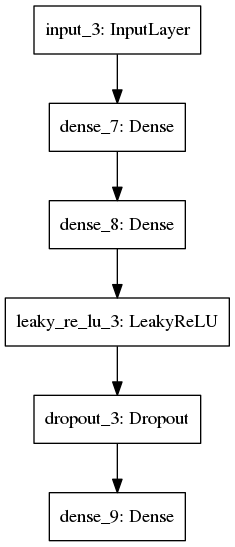

In [81]:
plot_model(model2)

In [82]:
model2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 17)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                180       
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 55        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 5)                 0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 6         
Total params: 241
Trainable params: 241
Non-trainable params: 0
_____________________________________________________________

In [83]:
max(train['meter_reading'])

1.0

In [84]:
# Train model on dataset
epochs = 5#TODO: change it back to 5
workers = 10
model2.fit_generator(generator=train_gen,
                    validation_data=val_gen, epochs=epochs, 
                    use_multiprocessing=True, workers = workers)

Epoch 1/1
13757/13757 [==============================] - 124s 9ms/step - loss: 0.1459 - mse: 0.0250 - mae: 0.1171 - mape: 21101702.0000 - val_loss: 0.1071 - val_mse: 0.0144 - val_mae: 0.0977 - val_mape: 22160182.0000


In [85]:
val_test_gen = TestDataGenerator(train[train['building_id'].isin(ids_val)], 
                                 col_names=col_names, 
                                 batch_size=batch_size)
print(len(val_test_gen))

val_test_res = model2.predict_generator(generator=val_test_gen, workers=12, use_multiprocessing=True)
val_test_res_og = pd.Series(np.expm1(scaler1.inverse_transform(val_test_res)).reshape(val_test_res.shape[0],))

x = []
for i in range(len(val_test_gen)):
    x.append(val_gen[i][1].values)

val_test_y = pd.Series(np.expm1(scaler1.inverse_transform(np.concatenate(x, axis=0).reshape(1, -1))).reshape(val_test_res.shape[0],))

print(len(val_test_y) == len(val_test_res_og))

5897
True


In [86]:
print("Error: " +str({np.sqrt(np.mean(np.square(val_test_res_og - val_test_y)))}))

Error: {2083.342737419364}


#### Defining Function for Prediction - Method 1

In [48]:
test_gen = TestDataGenerator(test, col_names=col_names, batch_size=batch_size)

In [49]:
len(test_gen)

40721

In [50]:
result = model2.predict_generator(generator=test_gen, workers=12, use_multiprocessing=True)

In [51]:
result# = None

array([[0.1793808 ],
       [0.17756706],
       [0.17690131],
       ...,
       [1.        ],
       [1.        ],
       [1.        ]], dtype=float32)

In [52]:
result.shape

(41697600, 1)

In [53]:
pd.Series(np.expm1(scaler1.inverse_transform(result)).reshape(result.shape[0],))

0           1.973727e+01
1           1.911119e+01
2           1.888615e+01
3           2.098601e+01
4           3.207375e+01
                ...     
41697595    2.190471e+07
41697596    2.190471e+07
41697597    2.190471e+07
41697598    2.190471e+07
41697599    2.190471e+07
Length: 41697600, dtype: float32

In [54]:
#len(pd.read_csv("gs://123test_bucket/test.csv"))

In [55]:
41697600/batch_size

40720.3125

In [56]:
result_df = pd.DataFrame({'meter_reading':pd.Series(np.expm1(scaler1.inverse_transform(result)).reshape(result.shape[0],)),
                         'row_id':test['row_id']})

In [57]:
result_df = result_df[['row_id', 'meter_reading']]

In [58]:
result_df.head(2)

,row_id,meter_reading
0,0,19.737267
1,1,19.111187


In [59]:
result_df.shape

(41697600, 2)

In [60]:
result_df.to_csv("gs://123test_bucket/result.csv", index=False)

In [61]:
check = pd.read_csv("result.csv")
check.shape

(41697600, 2)

In [68]:
result_df[result_df.meter_reading.isnull()]

,row_id,meter_reading


In [74]:
sample = pd.read_csv("gs://123test_bucket/sample_submission.csv")

In [76]:
sample['meter_reading'] = result_df['meter_reading']

In [77]:
sample = sample.fillna(0)

In [78]:
sample.to_csv("result_sample.csv", index=False)

In [79]:
# serialize model to JSON
model_json = model2.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model2.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
